# HW3 - Real Time Machine Learning
Jacob Barker
801075553

For this homework, we will use CIFAR-10, which comes with all three RGB input channels. Here is the link for loading CIFAR-10:

1. Train the based line VGG model we need for FashinMNIST on CIFAR-10 and report your classification accuracy for validation set, as well as training loss and training accuracy. For this training resize the network input to 64*64 resolution.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info
from keras_flops import get_flops
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import smart_resize

#**Data Preprocessing**
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Now separate out a validation set.
val_frac = 0.1
num_val_samples = int(len(train_images)*val_frac)
# choose num_val_samples indices up to the size of train_images, !replace => no repeats
val_idxs = np.random.choice(np.arange(len(train_images)), size=num_val_samples, replace=False)
trn_idxs = np.setdiff1d(np.arange(len(train_images)), val_idxs)
val_images = train_images[val_idxs, :,:,:]
train_images = train_images[trn_idxs, :,:,:]

val_labels = train_labels[val_idxs]
train_labels = train_labels[trn_idxs]

train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()
val_labels = val_labels.squeeze()

input_shape  = train_images.shape[1:]
print(input_shape)
train_images = train_images / 255.0
test_images  = test_images  / 255.0
val_images   = val_images   / 255.0


2023-03-08 21:49:08.806950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 21:49:09.452230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jacob/miniconda3/envs/tf/lib/
2023-03-08 21:49:09.452296: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jacob/miniconda3/envs/tf/lib/
2023-03-08 21:49:09.452302: W tensorflow/compiler/tf2ten

(32, 32, 3)


In [2]:
#Setting up VGG
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(
                tf.keras.layers.Conv2D(num_channels, kernel_size = 3,
                    padding='same', activation = 'relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

def VGG(arch):
    net = tf.keras.models.Sequential([
        tf.keras.layers.Resizing(64,64)])
    for (num_convs, num_channels) in arch:
        net.add(vgg_block(num_convs, num_channels))
    net.add(
            tf.keras.models.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(4096, activation = 'relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(4096, activation = 'relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(10)]))
    return net


Epoch 1/20
2813/2813 [==============================] - 69s 24ms/step - loss: 2.1583 - accuracy: 0.1888 - val_loss: 2.0061 - val_accuracy: 0.2704
Epoch 2/20
2813/2813 [==============================] - 65s 23ms/step - loss: 1.8036 - accuracy: 0.3367 - val_loss: 1.7545 - val_accuracy: 0.3576
Epoch 3/20
2813/2813 [==============================] - 65s 23ms/step - loss: 1.5310 - accuracy: 0.4466 - val_loss: 1.4762 - val_accuracy: 0.4672
Epoch 4/20
2813/2813 [==============================] - 65s 23ms/step - loss: 1.3567 - accuracy: 0.5136 - val_loss: 1.3587 - val_accuracy: 0.5024
Epoch 5/20
2813/2813 [==============================] - 65s 23ms/step - loss: 1.2064 - accuracy: 0.5686 - val_loss: 1.1973 - val_accuracy: 0.5770
Epoch 6/20
2813/2813 [==============================] - 65s 23ms/step - loss: 1.0637 - accuracy: 0.6217 - val_loss: 1.0855 - val_accuracy: 0.6242
Epoch 7/20
2813/2813 [==============================] - 65s 23ms/step - loss: 0.9199 - accuracy: 0.6754 - val_loss: 1.0541 -

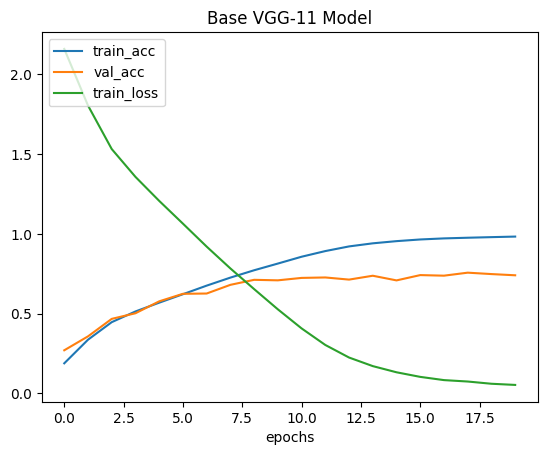

In [5]:
#Compileing and Training VGG-11
VGG_11 = VGG(arch=((1,64),(1,128),(2,256),(2,512),(2,512)))

VGG_11.compile(optimizer='SGD',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

history = VGG_11.fit(train_images, train_labels, batch_size=16, epochs=20, validation_data=(val_images, val_labels))

#Plotting Train, Val accuracy and train loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.title('Base VGG-11 Model')
plt.xlabel('epochs')
plt.legend(['train_acc', 'val_acc', 'train_loss'], loc = 'upper left')
plt.show()

In [6]:
#Getting Model Complexity and size
print("VGG-11")
flops = get_flops(VGG_11, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")
print(VGG_11.summary())

VGG-11


2023-03-08 16:05:56.886917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 16:05:56.887151: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-08 16:05:56.887209: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-08 16:05:56.887453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 16:05:56.887688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 16:05:56.887908: I tensorflow/compiler/x


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

2. Use Table 1 in the VGG paper (Simonyan and Zisserman, 2014) to construct other common models, such as VGG-16 or VGG-19. Train them on CIFAR-10, compare the accuracies, computational complexity and model size.

2023-03-08 16:06:20.210763: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 552960000 exceeds 10% of free system memory.
2023-03-08 16:06:20.577582: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/20
2813/2813 [==============================] - 112s 39ms/step - loss: 2.2594 - accuracy: 0.1404 - val_loss: 2.0832 - val_accuracy: 0.2376
Epoch 2/20
2813/2813 [==============================] - 106s 38ms/step - loss: 1.9668 - accuracy: 0.2743 - val_loss: 1.8523 - val_accuracy: 0.3224
Epoch 3/20
2813/2813 [==============================] - 105s 37ms/step - loss: 1.7665 - accuracy: 0.3507 - val_loss: 1.7023 - val_accuracy: 0.3990
Epoch 4/20
2813/2813 [==============================] - 105s 37ms/step - loss: 1.5320 - accuracy: 0.4402 - val_loss: 1.5920 - val_accuracy: 0.4270
Epoch 5/20
2813/2813 [==============================] - 105s 37ms/step - loss: 1.3480 - accuracy: 0.5135 - val_loss: 1.3415 - val_accuracy: 0.5266
Epoch 6/20
2813/2813 [==============================] - 105s 37ms/step - loss: 1.1913 - accuracy: 0.5692 - val_loss: 1.3503 - val_accuracy: 0.5394
Epoch 7/20
2813/2813 [==============================] - 105s 37ms/step - loss: 1.0289 - accuracy: 0.6334 - val_loss: 0

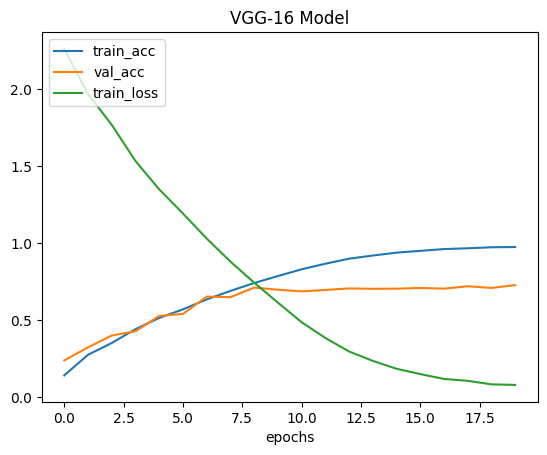

In [7]:
#*************************************************
'''VGG 16'''
#Implementing VGG 16
VGG_16 = VGG(arch=((2,64),(2,128),(3,256),(3,512),(3,512)))

VGG_16.compile(optimizer='SGD',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

history = VGG_16.fit(train_images, train_labels, batch_size=16, epochs=20, validation_data=(val_images, val_labels))

#Plotting loss and accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.title('VGG-16 Model')
plt.xlabel('epochs')
plt.legend(['train_acc', 'val_acc', 'train_loss'], loc = 'upper left')
plt.show()


In [8]:
#Getting Model Complexity and size
print("VGG-16")
flops = get_flops(VGG_16, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")
print(VGG_16.summary())

VGG-16


2023-03-08 16:41:56.830049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 16:41:56.830277: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-08 16:41:56.830343: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-08 16:41:56.830660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 16:41:56.830896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 16:41:56.831122: I tensorflow/compiler/x


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

2023-03-08 21:49:54.792874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 21:49:54.793949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 21:49:54.794307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 21:49:54.795243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/20


2023-03-08 21:49:59.405336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-03-08 21:50:00.221907: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9ec407da80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 21:50:00.221923: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-03-08 21:50:00.260510: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2813/2813 [==============================] - 138s 48ms/step - loss: 2.3028 - accuracy: 0.0987 - val_loss: 2.3031 - val_accuracy: 0.0914
Epoch 2/20
2813/2813 [==============================] - 142s 50ms/step - loss: 2.2749 - accuracy: 0.1293 - val_loss: 2.1387 - val_accuracy: 0.1980
Epoch 3/20
2813/2813 [==============================] - 139s 50ms/step - loss: 2.0022 - accuracy: 0.2536 - val_loss: 1.9372 - val_accuracy: 0.2864
Epoch 4/20
2813/2813 [==============================] - 139s 49ms/step - loss: 1.8229 - accuracy: 0.3218 - val_loss: 1.7148 - val_accuracy: 0.3700
Epoch 5/20
2813/2813 [==============================] - 141s 50ms/step - loss: 1.6709 - accuracy: 0.3867 - val_loss: 1.6834 - val_accuracy: 0.3718
Epoch 6/20
2813/2813 [==============================] - 134s 48ms/step - loss: 1.4873 - accuracy: 0.4581 - val_loss: 1.3590 - val_accuracy: 0.5112
Epoch 7/20
2813/2813 [==============================] - 130s 46ms/step - loss: 1.3258 - accuracy: 0.5190 - val_loss: 1.2569 - val

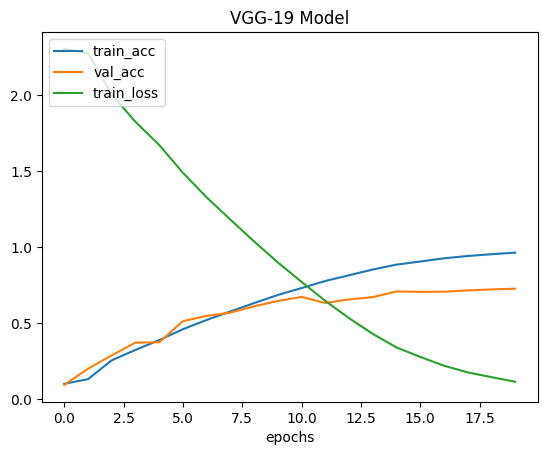

In [3]:
#*************************************************
'''VGG 19'''
#Implementing VGG 19
VGG_19 = VGG(arch=((2,64),(2,128),(4,256),(4,512),(4,512)))

VGG_19.compile(optimizer='SGD',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

history = VGG_19.fit(train_images, train_labels, batch_size=16, epochs=20, validation_data=(val_images, val_labels))

#Plotting accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.title('VGG-19 Model')
plt.xlabel('epochs')
plt.legend(['train_acc', 'val_acc', 'train_loss'], loc = 'upper left')
plt.show()


In [4]:
#Getting Model Complexity and size
print("VGG-19")
flops = get_flops(VGG_19, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")
print(VGG_19.summary())

VGG-19


2023-03-08 22:34:29.194225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 22:34:29.194462: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-08 22:34:29.194526: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-08 22:34:29.194866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 22:34:29.195098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 22:34:29.195320: I tensorflow/compiler/x

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model g

Problem 2 (30pts)

1. Use the CIFAR-10 to train a baseline classifier based on the GoogleNet model we did in lectures for 64*64 input resolution. Report your classification accuracy for the validation set, as well as training loss and training accuracy.

Epoch 1/20
2813/2813 [==============================] - 62s 19ms/step - loss: 2.4596 - accuracy: 0.1403 - val_loss: 2.3415 - val_accuracy: 0.1888
Epoch 2/20
2813/2813 [==============================] - 52s 19ms/step - loss: 1.8245 - accuracy: 0.3196 - val_loss: 1.6928 - val_accuracy: 0.3868
Epoch 3/20
2813/2813 [==============================] - 52s 19ms/step - loss: 1.5348 - accuracy: 0.4331 - val_loss: 1.5005 - val_accuracy: 0.4370
Epoch 4/20
2813/2813 [==============================] - 52s 19ms/step - loss: 1.3706 - accuracy: 0.4969 - val_loss: 1.3879 - val_accuracy: 0.4950
Epoch 5/20
2813/2813 [==============================] - 52s 19ms/step - loss: 1.2351 - accuracy: 0.5535 - val_loss: 1.1955 - val_accuracy: 0.5682
Epoch 6/20
2813/2813 [==============================] - 52s 19ms/step - loss: 1.1153 - accuracy: 0.5948 - val_loss: 1.2411 - val_accuracy: 0.5594
Epoch 7/20
2813/2813 [==============================] - 52s 19ms/step - loss: 1.0127 - accuracy: 0.6365 - val_loss: 0.9869 -

2023-03-08 22:55:44.885194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 22:55:44.885445: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-08 22:55:44.885524: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-08 22:55:44.886053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 22:55:44.886295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 22:55:44.886525: I tensorflow/compiler/x


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 64, 64, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)        4160      
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 192)       110784    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 192)        0         
 2D)                                                             
          

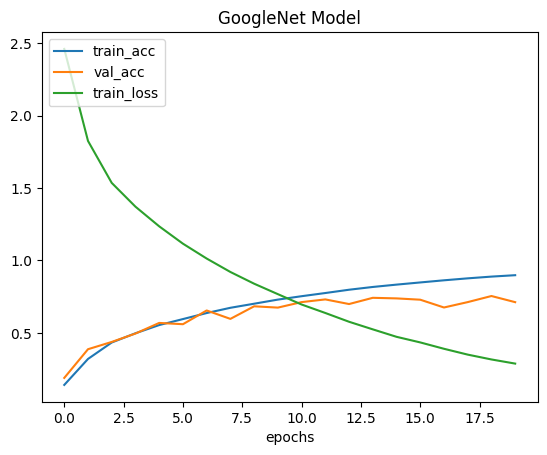

In [5]:
#********************************************************
'''GoogleNet'''

#Implementing GoogleNet 

#Inception Block
class Inception(tf.keras.Model):
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.b1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        self.b2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.b2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        self.b3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.b3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        self.b4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.b4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')

    def call(self, x):
        b1 = self.b1_1(x)
        b2 = self.b2_2(self.b2_1(x))
        b3 = self.b3_2(self.b3_1(x))
        b4 = self.b4_2(self.b4_1(x))
        return tf.keras.layers.Concatenate()([b1, b2, b3, b4])

class GoogleNet():
    def __init__(self):
        super().__init__()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Resizing(64,64),
            tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            tf.keras.layers.Conv2D(64,1,activation='relu'),
            tf.keras.layers.Conv2D(192,3,padding='same',activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            Inception(64, (96, 128), (16,32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            Inception(192, (96, 208), (16, 48), 64),
            Inception(160, (112, 224), (24, 64), 64),
            Inception(128, (128, 256), (24, 64), 64),
            Inception(112, (144, 288), (32, 64), 64),
            Inception(256, (160, 320), (32, 128), 128),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            Inception(256, (160, 320), (32, 128), 128),
            Inception(384, (192, 384), (48, 128), 128),
            tf.keras.layers.GlobalAvgPool2D(),
            tf.keras.layers.Flatten()])
    def train(self):
        self.net.compile(optimizer='SGD',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

        history = self.net.fit(train_images, train_labels, batch_size=16, epochs=20, validation_data=(val_images, val_labels))
        #Getting Model Complexity and size
        print("GoogleNet")
        flops = get_flops(self.net, batch_size=1)
        print(f"FLOPS: {flops / 10 ** 9:.03} G")
        print(self.net.summary())
        return history
    
model = GoogleNet()
googlenet = model.train()

#Plotting accuracy and loss
plt.plot(googlenet.history['accuracy'])
plt.plot(googlenet.history['val_accuracy'])
plt.plot(googlenet.history['loss'])
plt.title('GoogleNet Model')
plt.xlabel('epochs')
plt.legend(['train_acc', 'val_acc', 'train_loss'], loc = 'upper left')
plt.show()

2. Add batch normalization layer to GoogleNet (think about what is the best way of adding it). Train it again. Report your classification accuracy for the validation set, as well as training loss and training accuracy. Compare your accuracy against Problem2.1.

2023-03-08 17:42:37.294266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 552960000 exceeds 10% of free system memory.
2023-03-08 17:42:37.631942: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/20
2813/2813 [==============================] - 60s 19ms/step - loss: 3.0668 - accuracy: 0.3124 - val_loss: 2.4530 - val_accuracy: 0.1972
Epoch 2/20
2813/2813 [==============================] - 54s 19ms/step - loss: 1.3086 - accuracy: 0.5199 - val_loss: 2.4364 - val_accuracy: 0.3112
Epoch 3/20
2813/2813 [==============================] - 54s 19ms/step - loss: 1.0785 - accuracy: 0.6115 - val_loss: 1.0043 - val_accuracy: 0.6392
Epoch 4/20
2813/2813 [==============================] - 54s 19ms/step - loss: 0.9210 - accuracy: 0.6711 - val_loss: 1.2180 - val_accuracy: 0.5628
Epoch 5/20
2813/2813 [==============================] - 54s 19ms/step - loss: 0.8051 - accuracy: 0.7147 - val_loss: 0.8843 - val_accuracy: 0.7020
Epoch 6/20
2813/2813 [==============================] - 54s 19ms/step - loss: 0.7139 - accuracy: 0.7504 - val_loss: 0.7665 - val_accuracy: 0.7380
Epoch 7/20
2813/2813 [==============================] - 54s 19ms/step - loss: 0.6369 - accuracy: 0.7780 - val_loss: 0.9216 -

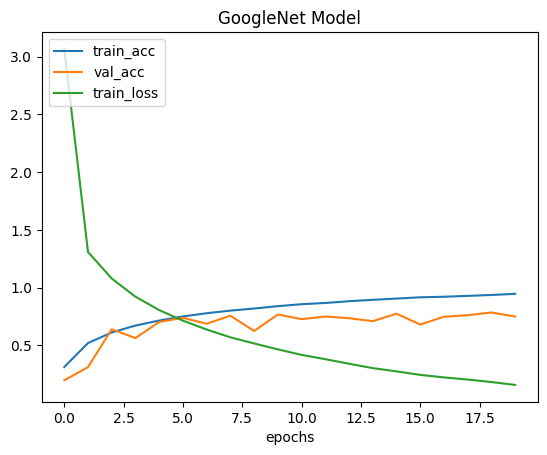

In [3]:
#********************************************************
'''GoogleNet with Batch Normalization'''

#Implementing GoogleNet with Batch Normalization 

#Inception Block
class Inception(tf.keras.Model):
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.b1_1 = tf.keras.layers.Conv2D(c1, 1, activation='relu')
        self.b2_1 = tf.keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.b2_2 = tf.keras.layers.Conv2D(c2[1], 3, padding='same',
                                           activation='relu')
        self.b3_1 = tf.keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.b3_2 = tf.keras.layers.Conv2D(c3[1], 5, padding='same',
                                           activation='relu')
        self.b4_1 = tf.keras.layers.MaxPool2D(3, 1, padding='same')
        self.b4_2 = tf.keras.layers.Conv2D(c4, 1, activation='relu')

    def call(self, x):
        b1 = self.b1_1(x)
        b2 = self.b2_2(self.b2_1(x))
        b3 = self.b3_2(self.b3_1(x))
        b4 = self.b4_2(self.b4_1(x))
        return tf.keras.layers.Concatenate()([b1, b2, b3, b4])

class GoogleNet():
    def __init__(self):
        super().__init__()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Resizing(64,64),
            tf.keras.layers.Conv2D(64, 7, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            tf.keras.layers.Conv2D(64,1),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.Conv2D(192,3,padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            Inception(64, (96, 128), (16,32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            Inception(192, (96, 208), (16, 48), 64),
            Inception(160, (112, 224), (24, 64), 64),
            Inception(128, (128, 256), (24, 64), 64),
            Inception(112, (144, 288), (32, 64), 64),
            Inception(256, (160, 320), (32, 128), 128),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            Inception(256, (160, 320), (32, 128), 128),
            Inception(384, (192, 384), (48, 128), 128),
            tf.keras.layers.GlobalAvgPool2D(),
            tf.keras.layers.Flatten()])
    def train(self):
        self.net.compile(optimizer='SGD',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

        history = self.net.fit(train_images, train_labels, batch_size=16, epochs=20, validation_data=(val_images, val_labels))
        return history
    
model = GoogleNet()
googlenet = model.train()

#Plotting accuracy and loss
plt.plot(googlenet.history['accuracy'])
plt.plot(googlenet.history['val_accuracy'])
plt.plot(googlenet.history['loss'])
plt.title('GoogleNet Model')
plt.xlabel('epochs')
plt.legend(['train_acc', 'val_acc', 'train_loss'], loc = 'upper left')
plt.show()

Problem 3 (40pts)

1. The baseline model we did in homework is called ResNet-18. Train that for CIFAR-10 and report and compare your validation accuracy against GoogleNet and VGGNet architectures you did. Can you compare the training time, model size and computation complexity across these three networks for CIFAR-10? Use 64*64 resolution across all training.

2023-03-08 20:06:17.164725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 20:06:17.166562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 20:06:17.166889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 20:06:17.167534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/20


2023-03-08 20:06:23.208850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-03-08 20:06:23.898041: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd8a232f6e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 20:06:23.898057: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-03-08 20:06:23.935676: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2813/2813 [==============================] - 54s 17ms/step - loss: 1.4163 - accuracy: 0.4950 - val_loss: 1.4246 - val_accuracy: 0.4922
Epoch 2/20
2813/2813 [==============================] - 48s 17ms/step - loss: 1.0002 - accuracy: 0.6495 - val_loss: 0.9885 - val_accuracy: 0.6494
Epoch 3/20
2813/2813 [==============================] - 48s 17ms/step - loss: 0.7837 - accuracy: 0.7251 - val_loss: 1.5899 - val_accuracy: 0.5360
Epoch 4/20
2813/2813 [==============================] - 48s 17ms/step - loss: 0.6178 - accuracy: 0.7833 - val_loss: 0.9283 - val_accuracy: 0.6850
Epoch 5/20
2813/2813 [==============================] - 48s 17ms/step - loss: 0.4743 - accuracy: 0.8353 - val_loss: 1.1965 - val_accuracy: 0.6208
Epoch 6/20
2813/2813 [==============================] - 48s 17ms/step - loss: 0.3618 - accuracy: 0.8731 - val_loss: 0.9590 - val_accuracy: 0.7016
Epoch 7/20
2813/2813 [==============================] - 48s 17ms/step - loss: 0.2711 - accuracy: 0.9034 - val_loss: 0.9334 - val_accura

2023-03-08 20:22:48.488216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 20:22:48.488517: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-08 20:22:48.488589: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-08 20:22:48.489075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 20:22:48.489298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 20:22:48.489510: I tensorflow/compiler/x

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model g

Non-trainable params: 7,808
_________________________________________________________________
None


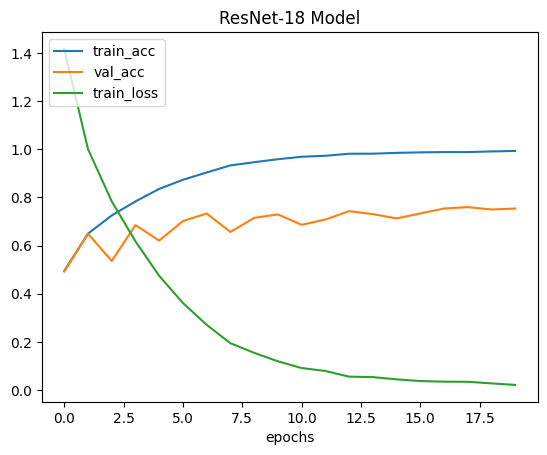

In [3]:
#************************************************
'''ResNet 18'''
#Implementing Resnet 18

class Residual(tf.keras.Model): 
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)
    
class ResNet():
    def __init__(self, arch, lr=0.1, num_classes=10):
        super(ResNet, self).__init__()
        self.net = tf.keras.models.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add(self.block(*b, first_block=(i==0)))
        self.net.add(tf.keras.models.Sequential([
            tf.keras.layers.GlobalAvgPool2D(),
            tf.keras.layers.Dense(units=num_classes)]))
        return self.net

    def block(self, num_residuals, num_channels, first_block=False):
        blk = tf.keras.models.Sequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(Residual(num_channels))
        return blk

    def b1(self):
        return tf.keras.models.Sequential([
            tf.keras.layers.Resizing(64,64),
            tf.keras.layers.Conv2D(64, kernel_size=7, strides=2,
                                   padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2,
                                      padding='same')])
    def train(self):
        self.net.compile(optimizer='SGD',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

        history = self.net.fit(train_images, train_labels, batch_size=16, epochs=20, validation_data=(val_images, val_labels))
        #Getting Model Complexity and size
        print("ResNet-18")
        flops = get_flops(self.net, batch_size=1)
        print(f"FLOPS: {flops / 10 ** 9:.03} G")
        print(self.net.summary())
        return history
    
#Implementing Resnet 18 model
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

model = ResNet18()
resnet18 = model.train()

#Plotting Accuracy and loss
plt.plot(resnet18.history['accuracy'])
plt.plot(resnet18.history['val_accuracy'])
plt.plot(resnet18.history['loss'])
plt.title('ResNet-18 Model')
plt.xlabel('epochs')
plt.legend(['train_acc', 'val_acc', 'train_loss'], loc = 'upper left')
plt.show()

2. Build two new versions of ResNet (ResNet-26, and ResNet-32). Train them on CIFAR-10. Plot the training loss, training accuracy and validation accuracy. Compare the classification accuracy, computation complexity, and model size across these three versions of ResNet (18, 26, 32). How does the complexity grow as you increase the network depth?

In [24]:
#*************************************
'''ResNet 26'''

'ResNet 26'

Epoch 1/20
2813/2813 [==============================] - 64s 21ms/step - loss: 1.4401 - accuracy: 0.4851 - val_loss: 1.7312 - val_accuracy: 0.4360
Epoch 2/20
2813/2813 [==============================] - 58s 21ms/step - loss: 1.0065 - accuracy: 0.6443 - val_loss: 1.1129 - val_accuracy: 0.6158
Epoch 3/20
2813/2813 [==============================] - 59s 21ms/step - loss: 0.7859 - accuracy: 0.7237 - val_loss: 1.1581 - val_accuracy: 0.6132
Epoch 4/20
2813/2813 [==============================] - 60s 21ms/step - loss: 0.6254 - accuracy: 0.7809 - val_loss: 1.0746 - val_accuracy: 0.6434
Epoch 5/20
2813/2813 [==============================] - 60s 21ms/step - loss: 0.4917 - accuracy: 0.8272 - val_loss: 1.1588 - val_accuracy: 0.6428
Epoch 6/20
2813/2813 [==============================] - 59s 21ms/step - loss: 0.3744 - accuracy: 0.8692 - val_loss: 0.9240 - val_accuracy: 0.7140
Epoch 7/20
2813/2813 [==============================] - 59s 21ms/step - loss: 0.2812 - accuracy: 0.9013 - val_loss: 1.1457 -

2023-03-08 19:44:21.030540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 19:44:21.030815: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-08 19:44:21.030881: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-08 19:44:21.031384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 19:44:21.031666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 19:44:21.031923: I tensorflow/compiler/x


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_58 (Sequential)  (None, 16, 16, 64)        9728      
                                                                 
 sequential_60 (Sequential)  (None, 16, 16, 64)        148736    
                                                                 
 sequential_61 (Sequential)  (None, 8, 8, 128)         823168    
                                                                 
 sequential_62 (Sequential)  (None, 4, 4, 256)         4466944   
                                                                 
 sequential_63 (Sequential)  (None, 2, 2, 512)         8399360   
                                                                 
 sequential_64 (Sequential)  (None, 10)                5130      
                                                                 
Total params: 13,853,066
Trainable params: 13,842,698
Non-trainable params: 

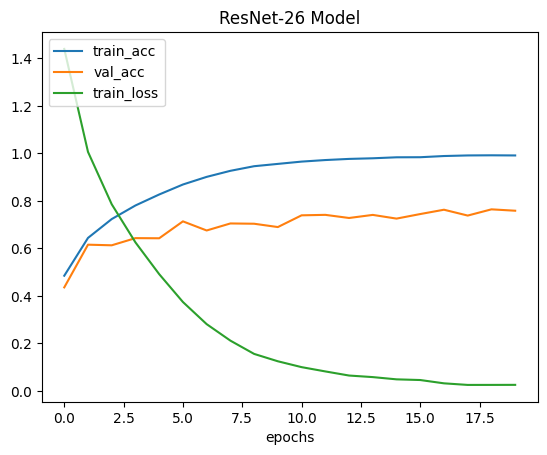

In [25]:
#Implememting ResNet 26 Model
class ResNet26(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (3, 128), (4, 256), (2, 512)),
                       lr, num_classes)

model = ResNet26()
resnet26 = model.train()
 #Plotting accuracy and loss
plt.plot(resnet26.history['accuracy'])
plt.plot(resnet26.history['val_accuracy'])
plt.plot(resnet26.history['loss'])
plt.title('ResNet-26 Model')
plt.xlabel('epochs')
plt.legend(['train_acc', 'val_acc', 'train_loss'], loc = 'upper left')
plt.show()

Epoch 1/20
2813/2813 [==============================] - 98s 33ms/step - loss: 1.5326 - accuracy: 0.4563 - val_loss: 1.1771 - val_accuracy: 0.5834
Epoch 2/20
2813/2813 [==============================] - 85s 30ms/step - loss: 1.0720 - accuracy: 0.6208 - val_loss: 1.1000 - val_accuracy: 0.6060
Epoch 3/20
2813/2813 [==============================] - 87s 31ms/step - loss: 0.8422 - accuracy: 0.7051 - val_loss: 1.0334 - val_accuracy: 0.6464
Epoch 4/20
2813/2813 [==============================] - 88s 31ms/step - loss: 0.6712 - accuracy: 0.7675 - val_loss: 1.0637 - val_accuracy: 0.6444
Epoch 5/20
2813/2813 [==============================] - 82s 29ms/step - loss: 0.5239 - accuracy: 0.8167 - val_loss: 1.3796 - val_accuracy: 0.5864
Epoch 6/20
2813/2813 [==============================] - 81s 29ms/step - loss: 0.4104 - accuracy: 0.8571 - val_loss: 1.5399 - val_accuracy: 0.5890
Epoch 7/20
2813/2813 [==============================] - 81s 29ms/step - loss: 0.3154 - accuracy: 0.8903 - val_loss: 1.3881 -

2023-03-08 20:50:56.731020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 20:50:56.731278: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-03-08 20:50:56.731340: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-08 20:50:56.731687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 20:50:56.731948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 20:50:56.732192: I tensorflow/compiler/x


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 16, 16, 64)        9728      
                                                                 
 sequential_9 (Sequential)   (None, 16, 16, 64)        223104    
                                                                 
 sequential_10 (Sequential)  (None, 8, 8, 128)         1119360   
                                                                 
 sequential_11 (Sequential)  (None, 4, 4, 256)         5649152   
                                                                 
 sequential_12 (Sequential)  (None, 2, 2, 512)         13123072  
                                                                 
 sequential_13 (Sequential)  (None, 10)                5130      
                                                                 
Total params: 20,129,546
Trainable params: 20,115,338
Non-trainable params: 

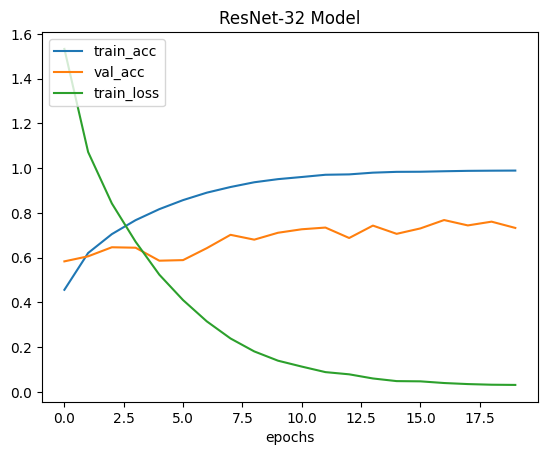

In [4]:
#*************************************
'''ResNet 32'''

#Implemeting ResNet 32 Model
class ResNet32(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((3, 64), (4, 128), (5, 256), (3, 512)),
                       lr, num_classes)

model = ResNet32()
resnet32 = model.train()

#Plotting accuracy and loss
plt.plot(resnet32.history['accuracy'])
plt.plot(resnet32.history['val_accuracy'])
plt.plot(resnet32.history['loss'])
plt.title('ResNet-32 Model')
plt.xlabel('epochs')
plt.legend(['train_acc', 'val_acc', 'train_loss'], loc = 'upper left')
plt.show()